In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 感知机

In [2]:
class Perception:
    def __init__(self, method='original') -> None:
        self.w = None
        self.b = None
        self.alpha = None
        self.n = 0
        self.method = method
        self.history = {
            'train_loss': [],
            'train_acc': []
        }
    
    # 初始化
    def init(self, X : np.ndarray, y : np.ndarray) -> None:
        if self.method == 'original':
            self.w = np.random.randn(X.shape[1],1)
            self.b = 0
        if self.method == 'dual':
            self.alpha = np.zeros((X.shape[0],1))
            self.b = 0
            self.w = (self.alpha*y*X).sum(axis=0).reshape(-1,1)
    
    # 损失
    def loss(self, X : np.ndarray, y : np.ndarray) -> float:
        false_set,_ = np.where(y*(np.matmul(X,self.w) + self.b) <= 0)
        if false_set.shape[0] > 0:
            return -(y[false_set]*(np.matmul(X[false_set],self.w) + self.b)).sum() / np.linalg.norm(self.w)
        else:
            return 0.0

    # 训练一次
    def update(self, X : np.ndarray, y : np.ndarray, valid_data : list, lr : float) -> bool:
        if self.method == 'original':
            false_set,_ = np.where(y*(np.matmul(X,self.w) + self.b) <= 0)
            if false_set.shape[0] == 0:
                return True
            else:
                index = np.random.choice(false_set,1)
                self.w += lr*y[index]*X[index].reshape(-1,1)
                self.b += lr*y[index]
                return False
        if self.method == 'dual':
            self.w = (self.alpha*y*X).sum(axis=0).reshape(-1,1)
            false_set,_ = np.where(y*(np.matmul(X,self.w) + self.b) <= 0)
            if false_set.shape[0] == 0:
                return True
            else:
                index = np.random.choice(false_set,1)
                self.alpha[index] += lr
                self.b += lr*y[index]
                return False
    
    # 训练
    def fit(self, X : np.ndarray, y : np.ndarray, valid_data=None, EPOCHS=1000, lr=0.1) -> None:
        self.init(X,y)
        flag = False
        if valid_data != None:
            self.history['valid_loss'] = []
            self.history['valid_acc'] = []
        epoch = 0
        while not flag and epoch < EPOCHS:
            self.history['train_loss'].append(self.loss(X,y))           
            self.history['train_acc'].append(self.accuracy(X,y))
            if valid_data != None:
                self.history['valid_loss'].append(self.loss(valid_data[0],valid_data[1]))
                self.history['valid_acc'].append(self.accuracy(valid_data[0],valid_data[1]))
            flag = self.update(X,y,valid_data,lr)
            self.n += 1
            epoch += 1
        print("训练次数：",self.n)
    
    # 预测
    def predict(self, X : np.ndarray) -> np.ndarray:
        y_pred = np.sign(np.matmul(X,self.w) + self.b)
        return y_pred
    
    # 准确率
    def accuracy(self, X : np.ndarray, y_true : np.ndarray) -> float:
        y_pred = self.predict(X)
        acc = np.sum(y_pred == y_true) / y_true.shape[0]
        return acc

## 测试

In [3]:
x_1 = np.concatenate((0.15*np.random.randn(100,1)+0.25,
                      0.15*np.random.randn(100,1)+0.75),axis=1)
x_2 = np.concatenate((0.15*np.random.randn(100,1)+0.75,
                      0.15*np.random.randn(100,1)+0.25),axis=1)
y_1 = np.ones((100,1))
y_2 = -np.ones((100,1))
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1,y_1,test_size=0.3)
x_2_train, x_2_test, y_2_train, y_2_test = train_test_split(x_2,y_2,test_size=0.3)
X_train = np.concatenate((x_1_train,x_2_train))
X_test = np.concatenate((x_1_test,x_2_test))
y_train = np.concatenate((y_1_train,y_2_train))
y_test = np.concatenate((y_1_test,y_2_test))

## 原始形式

训练次数： 132


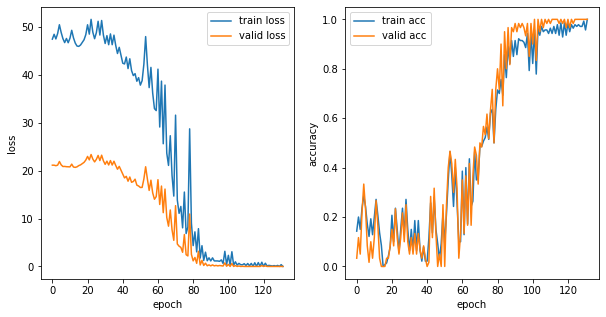

In [4]:
model = Perception('original')
model.fit(X_train,y_train,[X_test,y_test])
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flatten()
ax[0].plot(model.history['train_loss'],label='train loss')
ax[0].plot(model.history['valid_loss'],label='valid loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(model.history['train_acc'],label='train acc')
ax[1].plot(model.history['valid_acc'],label='valid acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

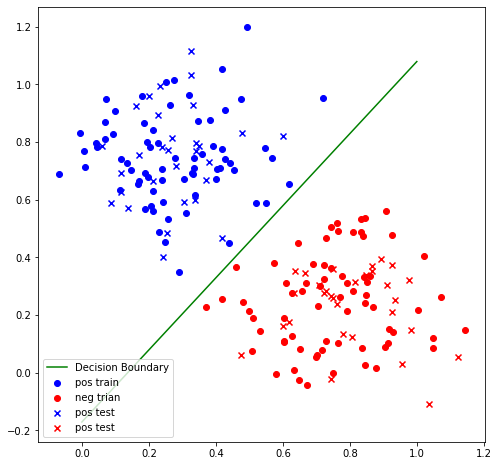

In [5]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x_1_train[:,0],x_1_train[:,1],c='b',label='pos train')
plt.scatter(x_2_train[:,0],x_2_train[:,1],c='r',label='neg trian')
plt.scatter(x_1_test[:,0],x_1_test[:,1],c='b',marker='x',label='pos test')
plt.scatter(x_2_test[:,0],x_2_test[:,1],c='r',marker='x',label='pos test')
x = np.linspace(0,1,100)
y = (-model.b/model.w[1] - x*(model.w)[0]/model.w[1]).reshape(100,)
plt.plot(x,y,c='g',label="Decision Boundary")
plt.legend(loc='lower left')

In [6]:
print("训练集正确率：",model.accuracy(X_train,y_train))
print("测试集正确率：",model.accuracy(X_test,y_test))

训练集正确率： 1.0
测试集正确率： 1.0


## 对偶形式

训练次数： 7


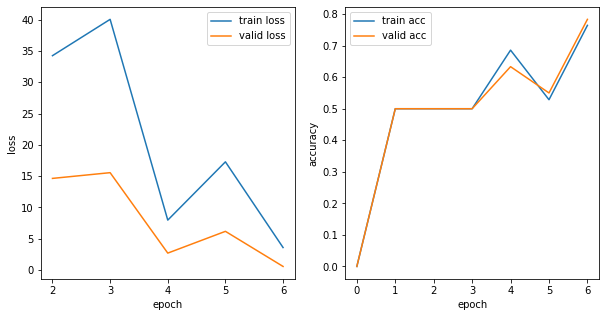

In [7]:
model = Perception('dual')
model.fit(X_train,y_train,[X_test,y_test])
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flatten()
ax[0].plot(model.history['train_loss'],label='train loss')
ax[0].plot(model.history['valid_loss'],label='valid loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(model.history['train_acc'],label='train acc')
ax[1].plot(model.history['valid_acc'],label='valid acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

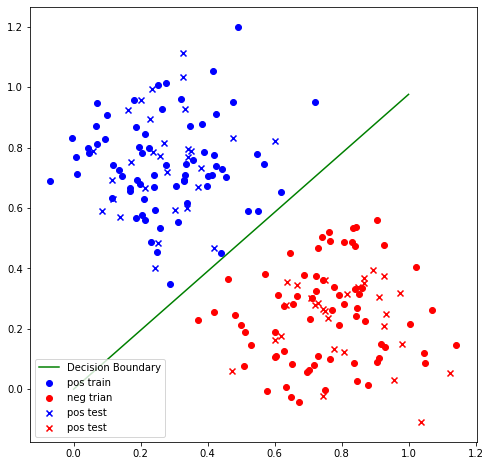

In [8]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x_1_train[:,0],x_1_train[:,1],c='b',label='pos train')
plt.scatter(x_2_train[:,0],x_2_train[:,1],c='r',label='neg trian')
plt.scatter(x_1_test[:,0],x_1_test[:,1],c='b',marker='x',label='pos test')
plt.scatter(x_2_test[:,0],x_2_test[:,1],c='r',marker='x',label='pos test')
x = np.linspace(0,1,100)
y = (-model.b/model.w[1] - x*(model.w)[0]/model.w[1]).reshape(100,)
plt.plot(x,y,c='g',label="Decision Boundary")
plt.legend(loc='lower left')

In [9]:
print("训练集正确率：",model.accuracy(X_train,y_train))
print("测试集正确率：",model.accuracy(X_test,y_test))

训练集正确率： 1.0
测试集正确率： 1.0
